# Prediksi Harga Mobil Bekas dengan Regresi Linear

## Section 1 : MARKET KENDARAAN BEKAS

### 1.1. Masalah Inti Market Mobil Bekas : Asimetri Informasi

maksudnya itu seperti penjual yang tahu banyak soal mobil bekas akan bisa memainkan harga, di lain sisi pembeli tidak tahu harga yang seharusnya. karena hal ini lah, kepercayaan turun, dan volume pembelian menurun. oleh karena itu, kita akan membangun model prediksi yang secara akurat bisa menentukan harga yang sesuai berdasarkan spesifikasi dari mobil bekas itu sendiri. dengan ini, pemangku kepentingan seperti penjual bisa memberikan harga yang lebih wajar, tidak rugi karena menjual terlalu rendah atau kehilangan pelanggan karena menjual terlalu tinggi. pembeli yang bisa lebih trust dengan harga yang sedikit lebih pasti dan valid.

### 1.2. Tujuan dan Pengukuran Kesuksesan

- Tujuan : membangun model machine learning regresi linear yang mampu secara akurat memprediksi harga mobil bekas dari fitur fiturnya.

- Metriks Teknis: Root Mean Square Error (RMSE). yang akan membandingkan harga hasil prediksi dengan harga aslinya. tapi dikuadratkan supaya model bisa lihat secara sensitif terhadap loss.

- Metriks Bisnis: Mean Absolute Error (MAE). bedanya cuma ini nilai yang lebih valid dan human.

model disini tidak hanya sebagai alat prediksi semata, namun juga bisa memberi tahu dengan valid dan masuk akal kenapa harga nya seperti itu. misal model bisa ngasi tau kalo harga bisa nurun sebesar X ketika mobil sudah berjalan M km. atau, mensegmentasi tipe mobil, sangat baik itu rata rata di atas X dollar.


---

## Section 2 : Exploratory Data Analysis (EDA)

*tujuan EDA adalah memahami dataset, menguji asumsi awal serta mengidentifikasi pola untuk feature engeneering*.

### 2.1. Dataset

source: *https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data*

In [4]:
import kagglehub
import os

# lokasi disimpan
dataset_dir = "kagglehub_datasets/austinreese/craigslist-carstrucks-data"

try:
    # cek eksistensi
    if os.path.exists(dataset_dir):
        print("Dataset sudah ada. Good to go!")
        path = dataset_dir
    else:
        # Download dataset
        path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")
        print("Dataset berhasil didownload ke:", path)

except Exception as e:
    print("Terjadi error:", str(e))

Dataset berhasil didownload ke: /kaggle/input/craigslist-carstrucks-data


In [5]:
import pandas as pd
csv_file = os.path.join(path, 'vehicles.csv')
df = pd.read_csv(csv_file)
df.shape

(426880, 26)

In [6]:
# informasi dataset

df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

---

**Analisis :**

1.  **Nilai Hilang yang Masif**: Terlihat perbedaan besar antara jumlah total baris (426,880) dan jumlah nilai `non-null` di banyak kolom.
    
    - `county` dan sepenuhnya kosong dan tidak berguna.
        
    - `size` hanya memiliki 120,519 nilai (hilang ~72% data).
        
    - `VIN` hilang lebih dari 62% data.
        
    - `condition` dan `cylinders` hilang sekitar 40% data.
        
    - drive dan paint_color juga memiliki tingkat kehilangan data yang signifikan.
        
        Ini menegaskan bahwa penanganan nilai hilang akan menjadi bagian penting dari pra-pemrosesan.
        
2. **Tipe Data yang Tidak Sesuai**:
    
    - `year` dan `odometer` direpresentasikan sebagai `float64` (angka desimal). `year` seharusnya adalah bilangan bulat (`int`), dan `odometer` juga.
        
3. **Fitur Kategorikal vs. Numerik**:

  - Sebagian besar kolom (18 dari 26) adalah tipe `object`, yang biasanya berarti string atau data teks. Ini adalah fitur-fitur kategorikal yang perlu di-encode menjadi angka agar bisa digunakan oleh model matematis.
    


In [7]:
# Informasi Statistik Dasar
# Menggunakan format agar lebih mudah dibaca
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,id,price,year,odometer,county,lat,long
count,426880.00,426880.00,425675.00,422480.00,0.00,420331.00,420331.00
mean,7311486634.22,75199.03,2011.24,98043.33,NaN,38.49,-94.75
std,4473170.41,12182282.17,9.45,213881.50,NaN,5.84,18.37
min,7207408119.00,0.00,1900.00,0.00,NaN,-84.12,-159.83
25%,7308143339.25,5900.00,2008.00,37704.00,NaN,34.60,-111.94
50%,7312620821.00,13950.00,2013.00,85548.00,NaN,39.15,-88.43
75%,7315253543.50,26485.75,2017.00,133542.50,NaN,42.40,-80.83
max,7317101084.00,3736928711.00,2022.00,10000000.00,NaN,82.39,173.89


---

**Analisis :**

Tabel statistik ini mengungkap anomali dan karakteristik penting dari data kita seperti:

1. **Kolom `price`**:
    
    - `min` adalah 0. Harga mobil tidak mungkin $0. Ini kemungkinan besar adalah _placeholder_ yang digunakan penjual untuk menarik klik.
        
    - `max` adalah $3,736,928,711. Ini jelas merupakan kesalahan input (_typo_) atau spam dan sama sekali tidak realistis.
        
    - `mean` ($75,199) jauh lebih tinggi dari `median` atau `50%` ($13,950). Perbedaan besar ini adalah indikasi kuat bahwa distribusi harga sangat miring ke kanan (_right-skewed_), di mana beberapa nilai yang sangat tinggi (outlier) menarik rata-rata ke atas.
        
2. **Kolom `year`**:
    
    - `min` adalah 1900. Meskipun mungkin ada mobil antik dari tahun tersebut, kemungkinan besar ini adalah data yang tidak valid atau _placeholder_. Mobil yang diproduksi secara massal sebelum tahun 1960-an sangat jarang di pasar mobil bekas umum.
        
3. **Kolom `odometer`**:
    
    - `min` adalah 0. Ini mungkin untuk mobil baru, tetapi bisa juga mencurigakan untuk mobil bekas (indikasi penggulungan odometer atau input yang salah).
        
    - `max` adalah 10,000,000 mil. Ini sangat tidak mungkin dan jelas merupakan outlier.
        
    - Sama seperti `price`, `mean` (98,043) sedikit lebih tinggi dari `median` (85,548), menunjukkan adanya kemiringan.
        

Wawasan dari `.describe()` ini bukan hanya tentang angka; ini adalah narasi tentang bagaimana data ini dibuat. Anomali ini bukan sekadar noise statistik, melainkan cerminan dari perilaku pengguna di platform Craigslist yang tidak terstruktur. Pemahaman ini krusial karena memandu kita untuk melakukan pembersihan data berdasarkan logika domain (misalnya, menetapkan batas harga dan tahun yang masuk akal) daripada hanya mengandalkan metode statistik buta untuk menangani outlier.

---

### 2.2. Hipotesis

*Berasumsi dan menggunakan visualisasi dan perhitungan untuk menguji asumsi untuk menemukan pola atau anomali tertentu*

**1. Analisis Variabel Target (price)**

**Hipotesis :**

*Banyak harga yang outlier, artinay berbeda dengan distribusi atau rata ratanya*

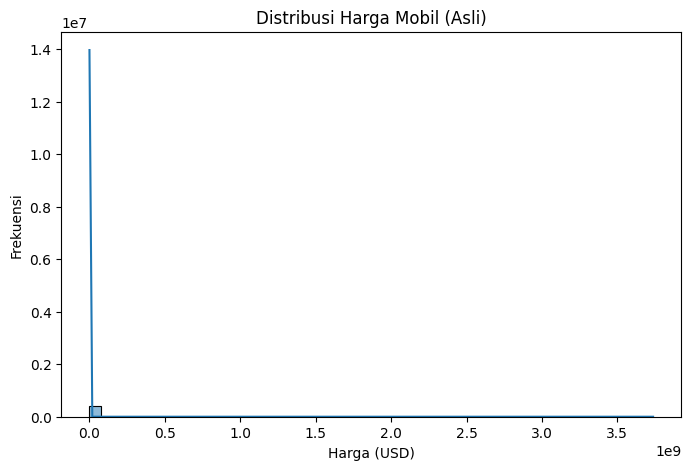

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter harga realistis
price_filtered = df[(df['price'] > 500) & (df['price'] < 100000)]

# Histogram harga asli
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribusi Harga Mobil (Asli)')
plt.xlabel('Harga (USD)')
plt.ylabel('Frekuensi')
plt.show()

*Histogram sangat miring ke kiri dan menumpuk di daerah nol, dengan ekor yang sangat panjang*

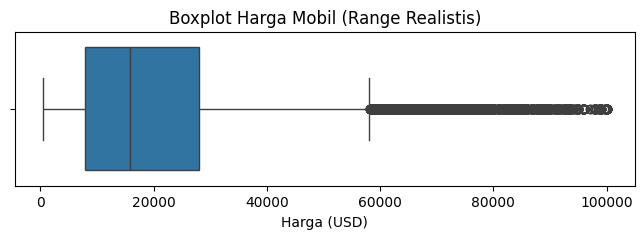

In [9]:
# Boxplot harga yang difilter
plt.figure(figsize=(8, 2))
sns.boxplot(x=price_filtered['price'])
plt.title('Boxplot Harga Mobil (Range Realistis)')
plt.xlabel('Harga (USD)')
plt.show()

box plot menunjukkan median di sekitar 15-20k doalr dengan banyak outlier di sebelah kanan.

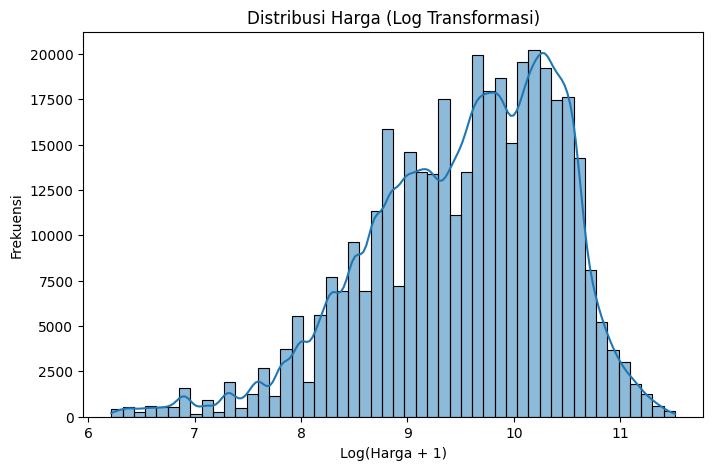

In [10]:
# Histogram harga setelah log transformasi
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(price_filtered['price']), bins=50, kde=True)
plt.title('Distribusi Harga (Log Transformasi)')
plt.xlabel('Log(Harga + 1)')
plt.ylabel('Frekuensi')
plt.show()

*histogram dengan distribusi lebih normal dan simetris tanpa outlier hasil operasi lograritmik*

---

**Analisis :**

1. Histogram Asli: Visualisasi pertama dengan jelas mengonfirmasi hipotesis kita. Distribusi harga memiliki "ekor panjang" ke kanan (long tail), yang berarti sebagian besar mobil memiliki harga di rentang bawah, tetapi ada beberapa mobil yang sangat mahal yang membuat distribusinya miring. Distribusi seperti ini dapat melanggar asumsi regresi linear.

2. Boxplot: Boxplot (setelah memfilter harga ekstrim untuk kejelasan) menunjukkan bahwa median harga berada di bawah $20,000, tetapi banyak sekali titik data (outlier) yang berada jauh di atas rentang interkuartil (kotak).

3. Histogram Transformasi Log: Setelah menerapkan transformasi logaritmik (np.log1p), distribusi harga menjadi jauh lebih simetris dan mendekati distribusi normal. Ini sangat penting karena salah satu asumsi regresi linear (OLS) adalah normalitas residual, dan memiliki variabel target yang terdistribusi normal seringkali membantu memenuhi asumsi tersebut.

**Kesimpulan :**

- Hipotesis terbukti benar. Kita harus membersihkan data harga dari nilai-nilai yang tidak realistis dan menerapkan transformasi log pada variabel target sebelum melakukan pemodelan.

**2. Multivairiat antara Variabel Independent usia mobil dan ordometer dengan dependent price**

**Hipotesis :**

*Semakin lama usia mobil atau semakin tinggi jarak tempunya semakin menurun harganya*

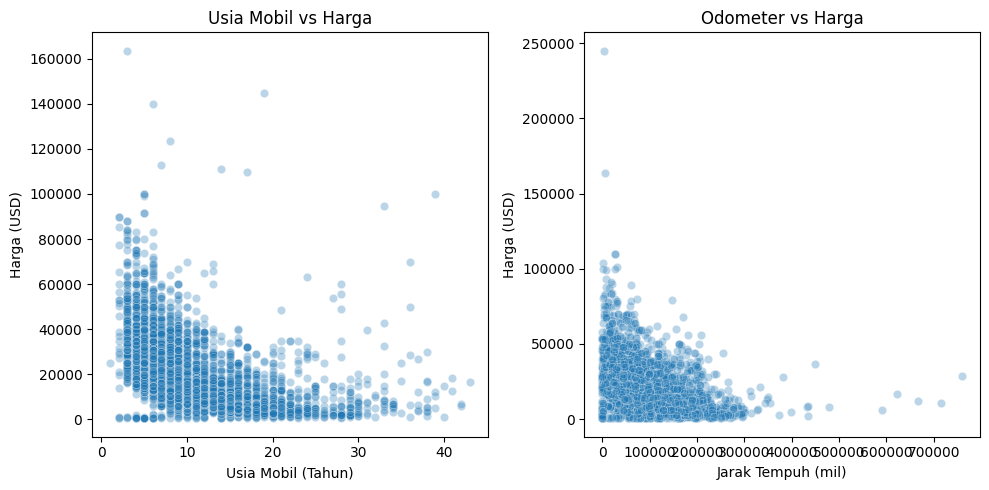

In [11]:
figsize = (10,5)

# 1. Buat fitur 'age'
df_cleaned = df[(df['year'] >= 1980) & (df['year'] <= 2023) &
                (df['price'] > 500) & (df['price'] < 250000)].copy()
df_cleaned['age'] = 2023 - df_cleaned['year']

# 2. Filter odometer
df_cleaned = df_cleaned[df_cleaned['odometer'] < 800000]

# 3. Scatter plot berdampingan
fig, axes = plt.subplots(1, 2, figsize=figsize)

sns.scatterplot(data=df_cleaned.sample(5000), x='age', y='price', alpha=0.3, ax=axes[0])
axes[0].set_title('Usia Mobil vs Harga')
axes[0].set_xlabel('Usia Mobil (Tahun)')
axes[0].set_ylabel('Harga (USD)')

sns.scatterplot(data=df_cleaned.sample(5000), x='odometer', y='price', alpha=0.3, ax=axes[1])
axes[1].set_title('Odometer vs Harga')
axes[1].set_xlabel('Jarak Tempuh (mil)')
axes[1].set_ylabel('Harga (USD)')

plt.tight_layout()
plt.show()

*kedua sketter plot menunjukkan persebaran atau tren yang menurun, yang artinya semakin tua atau smeakin tinggi km semakin turun harga mobil. walaupun ada bias dimana ada beberapa mobil yang km atau usianya sudah lama sekitar 30 th, tapi harganya masih tinggi*.

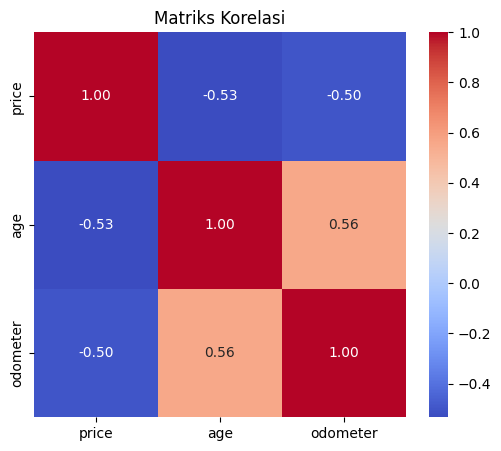

In [12]:
# 5. Heatmap korelasi
plt.figure(figsize=(6, 5))
numeric_cols = ['price', 'age', 'odometer']
corr_matrix = df_cleaned[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi')
plt.show()

*Heatmap diagram disini menjelaskan seberapa berhubungan variabel. bisa dilihat age dan ordometer dengan price sekitar -50an, moderate. justru age dan odometer yang berhubungan lebih besar, dan memang masuk akal karena semakin tua mobil semakin tinggi km yang ditempuh mobil tersebut*

---

**Analisis :**

1. Scatter Plots: Kedua plot dengan jelas menunjukkan tren negatif seperti yang dihipotesiskan. Seiring bertambahnya usia dan odometer, harga cenderung turun. Namun, ada banyak variasi (noise) di sekitar tren ini. Misalnya, pada usia 10 tahun, ada mobil yang harganya $5,000 dan ada yang 50,000 Ini menunjukkan bahwa meskipun usia dan odometer adalah prediktor penting, ada faktor lain yang juga sangat memengaruhi harga.

2. Heatmap Korelasi: Heatmap mengkuantifikasi apa yang kita lihat di scatter plot.

3. age memiliki korelasi negatif yang cukup kuat dengan price (-0.47).

4. odometer juga memiliki korelasi negatif yang moderat dengan price (-0.39).

5. Menariknya, age dan odometer memiliki korelasi positif (0.44), yang masuk akal: mobil yang lebih tua cenderung telah menempuh jarak yang lebih jauh. Hubungan antar fitur ini (multikolinearitas) adalah sesuatu yang perlu diperhatikan dalam pemodelan.

**Kesimpulan :**

- Hipotesis terbukti benar. age dan odometer adalah dua prediktor paling kuat yang kita miliki dan harus dimasukkan ke dalam model.

**3. Multivariat antara Kategori Mobil dengan Harga**

**Hipotesis :**

*fitur kategorikal sepreti merek, transmisi dan condition mempengaruhi harga mobil dengan signifikan, merek mewah, transmisi otomatis dan condition excellent akan memiliki harga median yang tinggi*

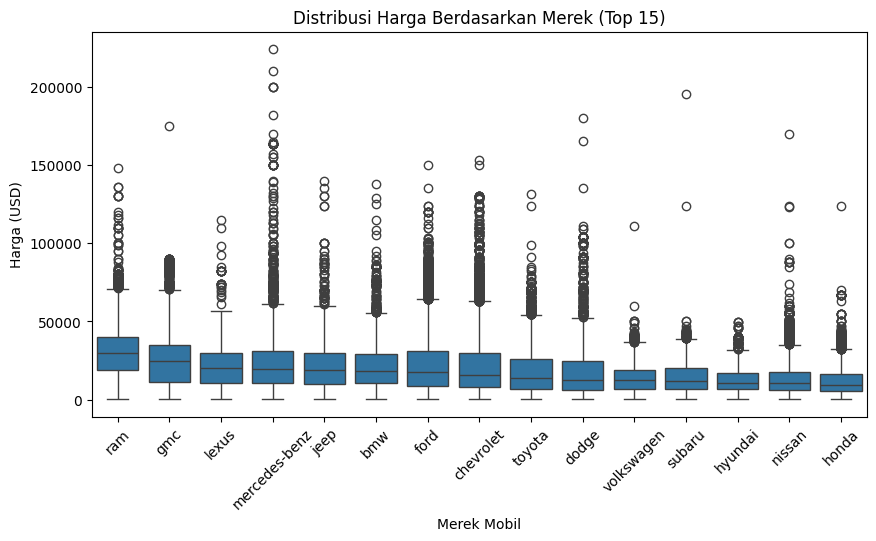

In [13]:
# 1. Ambil 15 merek dengan jumlah terbanyak
top_manufacturers = df_cleaned['manufacturer'].value_counts().nlargest(15).index
df_top_manuf = df_cleaned[df_cleaned['manufacturer'].isin(top_manufacturers)]

# Urutkan berdasarkan median harga
order = df_top_manuf.groupby('manufacturer')['price'].median().sort_values(ascending=False).index

# Plot 1: Harga berdasarkan Merek
plt.figure(figsize=figsize)
sns.boxplot(data=df_top_manuf, x='manufacturer', y='price', order=order)
plt.title('Distribusi Harga Berdasarkan Merek (Top 15)')
plt.xlabel('Merek Mobil')
plt.ylabel('Harga (USD)')
plt.xticks(rotation=45)
plt.show()

*Sebuah boxplot besar yang menunjukkan distribusi harga untuk 15 merek. Merek seperti 'ram', 'gmc', 'chevrolet', dan 'ford' menunjukkan rentang harga yang luas dan median yang tinggi. Merek seperti 'honda', 'hyundai', dan 'nissan' memiliki median yang lebih rendah*.

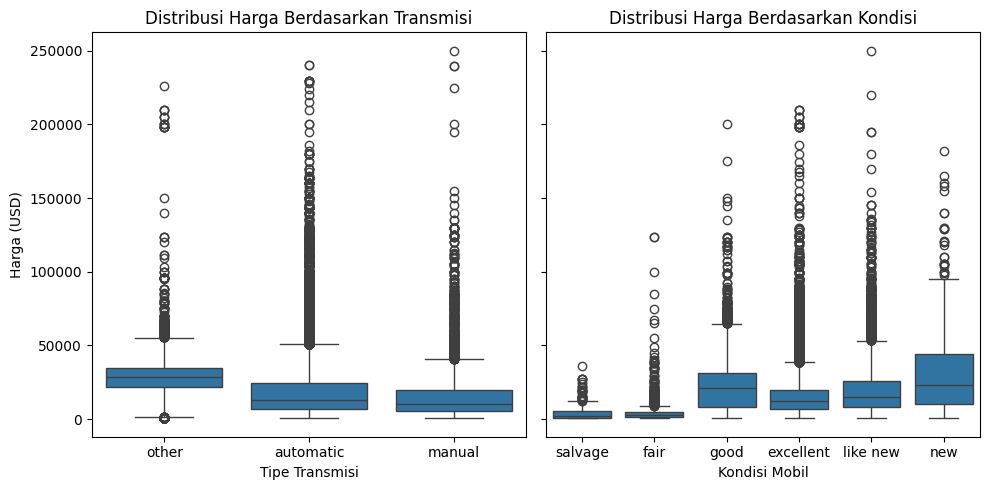

In [14]:
# Plot 2 & 3: Harga berdasarkan Transmisi dan Kondisi
fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

sns.boxplot(data=df_cleaned, x='transmission', y='price', ax=axes[0])
axes[0].set_title('Distribusi Harga Berdasarkan Transmisi')
axes[0].set_xlabel('Tipe Transmisi')
axes[0].set_ylabel('Harga (USD)')

sns.boxplot(data=df_cleaned, x='condition', y='price',
            order=['salvage', 'fair', 'good', 'excellent', 'like new', 'new'], ax=axes[1])
axes[1].set_title('Distribusi Harga Berdasarkan Kondisi')
axes[1].set_xlabel('Kondisi Mobil')
axes[1].set_ylabel('')  # Kosongkan label y

plt.tight_layout()
plt.show()

*Dua boxplot berdampingan. Plot kiri (Transmisi) menunjukkan bahwa median harga untuk 'automatic' secara signifikan lebih tinggi daripada 'manual'. Plot kanan (Kondisi) menunjukkan tren yang jelas: semakin baik kondisinya (dari 'salvage' ke 'new'), semakin tinggi median harganya*.

**Analisis :**

1. Merek Mobil : Visualisasi ini dengan jelas menunjukkan bahwa merek adalah penentu harga yang sangat kuat. Merek yang dikenal dengan truk dan SUV (seperti Ford, Chevrolet, GMC, Ram) memiliki median harga yang lebih tinggi dan distribusi yang lebih luas, mencerminkan variasi model dari truk kerja dasar hingga SUV mewah. Merek seperti Honda dan Hyundai, yang dikenal dengan mobil yang lebih ekonomis, memiliki median harga yang lebih rendah. Ini memvalidasi bahwa manufacturer adalah fitur prediktif yang krusial.

2. Transmisi : Seperti yang dihipotesiskan, mobil dengan transmisi automatic secara konsisten memiliki harga jual yang lebih tinggi daripada mobil manual. Ini mencerminkan preferensi pasar di AS.

3. Kondisi : Ada hubungan yang sangat logis dan monoton antara kondisi dan harga. Semakin baik kondisi mobil, semakin tinggi harganya. Ini menegaskan bahwa condition adalah fitur yang sangat berharga, meskipun memiliki banyak nilai yang hilang yang perlu kita tangani.

**Kesimpulan :**

- Hipotesis terbukti benar. Fitur-fitur kategorikal ini membawa sinyal yang kuat dan harus di-encode untuk dimasukkan ke dalam model kita.

### 2.4. Handling Missing Values - Its not just about a junk

*dataset punya pola untik untuk nilai yang hilang, ga sepenuhnya acak, jadi harus kita lihat apakah null value make sanse atau tidak, dan setelahnya kita bisa handle sesuai dengan logikanya*

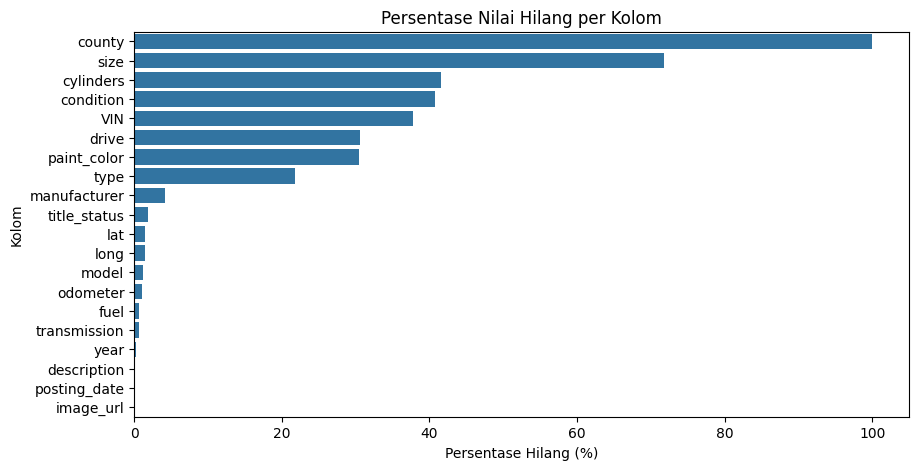

In [15]:
import missingno as msno

# 1. Menghitung persentase nilai hilang per kolom
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({'Column': missing_percentage.index, 'Missing Percentage': missing_percentage.values})
missing_info = missing_info.sort_values(by='Missing Percentage', ascending=False)
missing_info = missing_info[missing_info['Missing Percentage'] > 0]

# Plot batang untuk persentase nilai hilang
plt.figure(figsize=figsize)
sns.barplot(data=missing_info, x='Missing Percentage', y='Column')
plt.title('Persentase Nilai Hilang per Kolom')
plt.xlabel('Persentase Hilang (%)')
plt.ylabel('Kolom')
plt.show()

*Sebuah plot batang horizontal yang menunjukkan persentase nilai hilang. 'county' berada di 100%. 'size' berada di sekitar 72%, 'VIN' di 40%, 'condition' dan 'cylinders' di sekitar 45%, diikuti oleh kolom lain dengan persentase yang lebih kecil*.

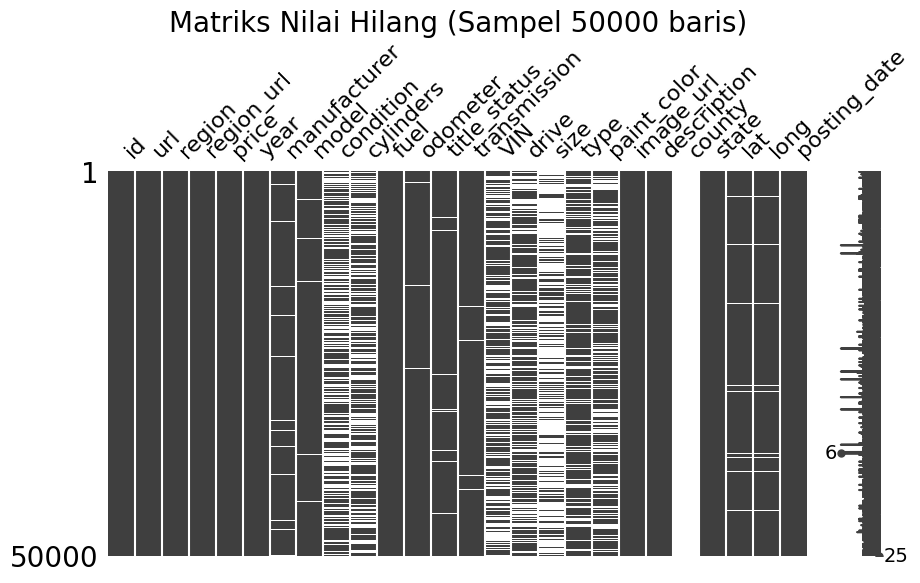

In [16]:
# 2. Visualisasi matriks nilai hilang dengan missingno
# Mengambil sampel 50000 baris agar plot tidak terlalu padat dan cepat dirender
msno.matrix(df.sample(50000), figsize=figsize)
plt.title('Matriks Nilai Hilang (Sampel 50000 baris)', fontsize=20)
plt.show()

*Dari visualisasi missing value matrix, kita melihat bahwa kolom seperti size, type, dan VIN memiliki proporsi missing yang tinggi. Sementara itu, kolom price, year, dan region hampir selalu lengkap. Untuk model prediktif, kita bisa mempertimbangkan menghapus kolom dengan missing yang terlalu besar, dan melakukan imputasi atau pengisian data untuk kolom penting lainnya seperti condition dan odometer*.

---

**Analisis :**

1. Plot Batang: Plot ini mengkuantifikasi masalah yang kita identifikasi dengan .info(). Kolom county benar-benar kosong. size kehilangan hampir tiga perempat datanya, membuatnya hampir tidak dapat digunakan. VIN, condition, dan cylinders juga memiliki masalah serius.

2. Matriks missingno: Visualisasi ini lebih dari sekadar hitungan; ini menunjukkan pola. Garis-garis putih horizontal yang membentang di beberapa kolom menunjukkan bahwa ketika satu nilai hilang, nilai lain juga cenderung hilang untuk iklan yang sama. Misalnya, ada korelasi dalam kehilangan data antara condition, cylinders, dan drive.

Pola-pola ini menunjukkan bahwa kehilangan data tidak sepenuhnya acak. Ini bisa disebabkan oleh beberapa alasan:

- Tidak Relevan: Fitur size mungkin tidak relevan untuk tipe mobil tertentu (misalnya, sedan) sehingga dibiarkan kosong oleh penjual.

- Kerahasiaan: Penjual mungkin sengaja tidak memasukkan VIN karena alasan privasi.

- Malas: Penjual mungkin hanya mengisi kolom-kolom yang wajib dan mengabaikan sisanya.

Pemahaman ini sangat penting untuk tahap selanjutnya. Daripada hanya menghapus baris atau mengisi nilai hilang dengan modus global, kita dapat merancang strategi imputasi yang lebih cerdas. Misalnya, untuk mengisi drive (FWD/RWD/4WD) yang hilang, kita bisa melihat modus drive untuk tipe mobil yang sama (misalnya, sebagian besar 'pickup' adalah '4wd' atau 'rwd'). Ini adalah pendekatan yang jauh lebih canggih dan berbasis data.

---

## Section 3 : Preprocessing and Feature Engeneering

*Mengubah data mentah menjadi siap pakai untuk model, valid dan bersih.*


dan kita bakal track data kita, kaya jumlah kolom dan barisnya tiap abis proses.

### 3.1. Data Cleaning and Outlier Handling

**Justifikasi :**

berdasarkan EDA, kita tahu ada beberapa data yang tidak masuk akal di kolom price, odometer dan tahun. sehingga kita akan menerapkan filter, dengan logika yang masuk akal, lebih ke membatasi batas atas dan bawah dari tiap kolom yang lebih masuk akal

In [17]:
# Tampilkan bentuk data sebelum pembersihan
print(f"Bentuk data sebelum pembersihan: {df.shape}")

# Terapkan filter berdasarkan logika domain
# Harga: antara $500 dan $250,000
# Tahun: antara 1980 dan 2023
# Odometer: antara 100 dan 800,000 mil
df_processed = df[
    (df['price'] > 500) & (df['price'] < 250000) &
    (df['year'] >= 1980) & (df['year'] <= 2023) &
    (df['odometer'] > 100) & (df['odometer'] < 800000)
].copy()

# Tampilkan bentuk data setelah pembersihan
print(f"Bentuk data setelah pembersihan outlier: {df_processed.shape}")

Bentuk data sebelum pembersihan: (426880, 26)
Bentuk data setelah pembersihan outlier: (367894, 26)


### 3.2. Handilng Missing Values NaN

**Justifikasi :**

diakarenakan model tidak bisa bekerja jika ada data NaN, kita akan menghilangkan atau mengggantikan nilai nan ini dengan pedoman berdasarkan EDA poin 2.4.

In [18]:
print("Bentuk data awal:", df.shape)
print("Jumlah nilai hilang awal:\n", df.isnull().sum())


#  HAPUS KOLOM YANG TIDAK PERLU ATAU TERLALU KOSONG
# Kolom tidak relevan untuk modeling + kolom yang >40% NaN
cols_to_drop = [
    'id', 'url', 'region_url', 'VIN', 'image_url', 'description', # Tidak relevan
    'county', 'size', # Terlalu banyak NaN
    'cylinders' # Sesuai keputusan strategi awal Anda (>40%)
]

df_processed = df_processed.drop(columns=cols_to_drop)

print(f"Menghapus {len(cols_to_drop)} kolom. Kolom yang dihapus: {cols_to_drop}")
print("Bentuk data setelah menghapus kolom:", df_processed.shape)


Bentuk data awal: (426880, 26)
Jumlah nilai hilang awal:
 id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64
Menghapus 9 kolom. Kolom yang dihapus: ['id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'county', 'size', 'cylinders']
Bentuk data setelah menghapus kolom: (367894, 17)


In [19]:
# IMPUTASI KOLOM KATEGORIKAL
# Kolom yang akan kita isi NaN-nya dengan modus
cols_to_impute = [
    'manufacturer', 'model', 'condition', 'fuel',
    'title_status', 'transmission', 'drive', 'type', 'paint_color'
]

for col in cols_to_impute:
    mode_val = df_processed[col].mode()[0]
    df_processed[col] = df_processed[col].fillna(mode_val)

print("Imputasi modus selesai untuk kolom-kolom yang relevan.")
# Mari kita cek NaN setelah imputasi
print("Jumlah nilai hilang SETELAH IMPUTASI:\n", df_processed.isnull().sum())

Imputasi modus selesai untuk kolom-kolom yang relevan.
Jumlah nilai hilang SETELAH IMPUTASI:
 region             0
price              0
year               0
manufacturer       0
model              0
condition          0
fuel               0
odometer           0
title_status       0
transmission       0
drive              0
type               0
paint_color        0
state              0
lat             3244
long            3244
posting_date       0
dtype: int64


In [20]:
# HAPUS BARIS DENGAN SISA NaN YANG SEDIKIT
# Sekarang, satu-satunya kolom yang mungkin masih punya NaN adalah 'lat' dan 'long'.
# Karena jumlahnya sedikit, kita aman untuk menghapus baris-baris ini.
initial_rows = len(df_processed)
df_processed.dropna(inplace=True)
final_rows = len(df_processed)

print(f"Menghapus {initial_rows - final_rows} baris yang masih memiliki NaN (dari kolom 'lat', 'long', dll).")

Menghapus 3244 baris yang masih memiliki NaN (dari kolom 'lat', 'long', dll).


In [21]:
# HASIL AKHIR
print("[HASIL AKHIR]")
print("Jumlah nilai hilang FINAL IMPUTASI:\n", df_processed.isnull().sum())
print("Jumlah nilai hilang FINAL:", df_processed.isnull().sum().sum()) # Total harus 0
print(f"Bentuk data final siap untuk modeling: {df_processed.shape}")

[HASIL AKHIR]
Jumlah nilai hilang FINAL IMPUTASI:
 region          0
price           0
year            0
manufacturer    0
model           0
condition       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
lat             0
long            0
posting_date    0
dtype: int64
Jumlah nilai hilang FINAL: 0
Bentuk data final siap untuk modeling: (364650, 17)


### 3.3. Feature Engeneering and Transformation


**Justifikasi :**

feture egeneering : mengubah kolom year menjadi age agar lebih intuitif.

transformation : menerapkan transformasi logaritmik pada kolom ordometer dan price, agar distribusi lebih stabil dan merata.

In [22]:
# 1. Rekayasa fitur 'age'
df_processed['age'] = 2023 - df_processed['year']
df_processed.drop(columns=['year'], inplace=True) # Hapus kolom 'year' asli

# 2. Terapkan transformasi logaritmik
df_processed['price_log'] = np.log1p(df_processed['price'])
df_processed['odometer_log'] = np.log1p(df_processed['odometer'])

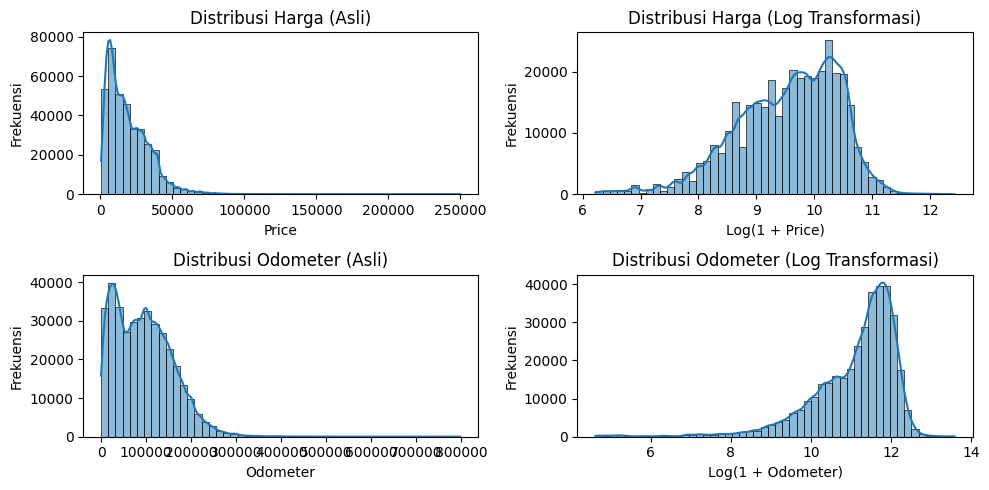

In [23]:
# Visualisasi histogram distribusi sebelum dan sesudah transformasi log
fig, axes = plt.subplots(2, 2, figsize=figsize)

# Histogram Harga Asli
sns.histplot(df_processed['price'], bins=50, kde=True, ax=axes[0][0])
axes[0][0].set_title('Distribusi Harga (Asli)')
axes[0][0].set_xlabel('Price')
axes[0][0].set_ylabel('Frekuensi')

# Histogram Harga Log
sns.histplot(df_processed['price_log'], bins=50, kde=True, ax=axes[0][1])
axes[0][1].set_title('Distribusi Harga (Log Transformasi)')
axes[0][1].set_xlabel('Log(1 + Price)')
axes[0][1].set_ylabel('Frekuensi')

# Histogram Odometer Asli
sns.histplot(df_processed['odometer'], bins=50, kde=True, ax=axes[1][0])
axes[1][0].set_title('Distribusi Odometer (Asli)')
axes[1][0].set_xlabel('Odometer')
axes[1][0].set_ylabel('Frekuensi')

# Histogram Odometer Log
sns.histplot(df_processed['odometer_log'], bins=50, kde=True, ax=axes[1][1])
axes[1][1].set_title('Distribusi Odometer (Log Transformasi)')
axes[1][1].set_xlabel('Log(1 + Odometer)')
axes[1][1].set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()

### 3.4. Encoding Categorical Features

**Justifikasi :**

Fitur seperti ; manufacturer, condition, cylinders, fuel, title_status, transmission, drive, size, type, paint_color harus di ubah menjadi numerikal dengan proses one hot encoding sebelum di train ke model

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [25]:
# Tampilkan bentuk data sebelum encoding
print(f"Bentuk data sebelum One-Hot Encoding: {df_processed.shape}")

Bentuk data sebelum One-Hot Encoding: (364650, 19)


In [ ]:
# Pilih kolom kategorikal untuk di-encode
# Kita akan mengecualikan 'model' untuk saat ini karena memiliki terlalu banyak nilai unik
# Kita juga akan mengecualikan 'region' dan 'state_id' untuk menyederhanakan model awal
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('model')
categorical_cols.remove('region')
categorical_cols.remove('state')

# Terapkan One-Hot Encoding
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

# Tampilkan bentuk data setelah encoding
print(f"Bentuk data setelah One-Hot Encoding: {df_encoded.shape}")